# Synthesis planning

### Full-route reranking.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("liac/steer-test")

summary_list, config_list, name_list = [], [], []
for run in runs:
    if (int(run.name.split('-')[-1]) < 234):
        continue
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(pd.Series(run.summary._json_dict))

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        pd.Series({k: v for k,v in run.config.items()
          if not k.startswith('_')}))

    # .name is the human-readable name of the run.
    name_list.append(run.name)


df_summ = pd.concat(summary_list, axis=1)
df_conf = pd.concat(config_list, axis=1)

df = pd.concat([df_summ, df_conf]).T

corr_cols = df.columns[df.columns.str.startswith('corr')]

/tmp/ipykernel_3594083/3280154377.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))
/tmp/ipykernel_3594083/3280154377.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))
/tmp/ipykernel_3594083/3280154377.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))
/tmp/ipykernel_3594083/3280154377.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append

In [2]:
corr_cols = [
    'corr_00813afd159c009f6a6c9bf1207b07f4',
    'corr_1002fe2d610a74e4478530e12ab930e3',
    'corr_1823f3241b82133bbca85d6576cbed65',
    'corr_280b79ef56e06a8af1a7d6b72c52148d',
    'corr_46f06d1a1e359b3230cfc1b81473a474',
    'corr_4bfe366ec7f5d64678d500f9084cbb35',
    'corr_564d6fbe8d4540931e8a93ef36c895e2',
    'corr_6137420e765c02d74671c89ca569ce41',
    'corr_b7593440c612f17a7201aef6d6667d0b',
    'corr_ca06156bee8f14dcf0bd7e14f68eddcc',
    'corr_dfc8116ec63329c437281f7a40dda876',
    'corr_e579d80f176371344bab95ea15e6b9ab',
    'corr_ea8df340d54596eda93e23f04dff3a9b'
]

In [3]:
# drop columns where "corr_00813afd159c009f6a6c9bf1207b07f4" is nan

# drop all rows where many corr cols are nan or 0
df = df.loc[(~((df[corr_cols] == 0) | df[corr_cols].isna())).sum(axis=1)>10]
df

,_runtime,_step,_timestamp,_wandb,corr_00813afd159c009f6a6c9bf1207b07f4,corr_1002fe2d610a74e4478530e12ab930e3,corr_1823f3241b82133bbca85d6576cbed65,corr_280b79ef56e06a8af1a7d6b72c52148d,corr_46f06d1a1e359b3230cfc1b81473a474,corr_4bfe366ec7f5d64678d500f9084cbb35,...,mae_target3,mae_target4,corr_0c0ea36bcefee71d4956cfc21454fe12,corr_bf6e6641ffc7bf54d328bdb1568e1787,mae_0c0ea36bcefee71d4956cfc21454fe12,mae_bf6e6641ffc7bf54d328bdb1568e1787,model,prompt,vision,results_dir
0,254.584723,13,1736888988.897232,{'runtime': 254},0.166059,0.633014,0.768265,0.784767,0.665338,-0.226217,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-3-5-sonnet,steer.llm.prompts.route_opt,False,data/2025-01-14_220533
1,249.763905,13,1736889151.357946,{'runtime': 249},-0.049988,0.704266,0.739848,0.764098,0.692289,-0.062057,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-3-5-sonnet,steer.llm.prompts.route_opt,False,data/2025-01-14_220820
2,992.182528,13,1736889930.99117,{'runtime': 992},-0.127753,-0.142779,0.162017,0.113924,-0.144098,0.088114,...,NaN,NaN,NaN,NaN,NaN,NaN,gpt-4o-mini,steer.llm.prompts.route_opt,False,data/2025-01-14_220858
3,38.181563,13,1736888995.804186,{'runtime': 37},-0.221706,-0.068395,-0.064843,-0.089364,-0.013737,-0.208782,...,NaN,NaN,NaN,NaN,NaN,NaN,random,steer.llm.prompts.route_opt,False,data/2025-01-14_220916
4,876.810791,13,1736889863.803812,{'runtime': 876},0.210107,0.184499,0.471676,0.673327,-0.150553,-0.024503,...,NaN,NaN,NaN,NaN,NaN,NaN,gpt-4o,steer.llm.prompts.route_opt,False,data/2025-01-14_220946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,528.918436,13,1750755063.259333,{'runtime': 528},-0.020606,0.03786,0.397182,0.298774,0.109205,0.154013,...,NaN,NaN,NaN,NaN,NaN,NaN,gemini-2.0-flash,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_104213
279,2156.69611,13,1750756899.405321,{'runtime': 2156},-0.127178,-0.108622,0.169194,-0.199068,0.196574,0.162478,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-2.1,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_104541
280,608.954177,13,1750755566.14774,{'runtime': 608},0.018355,0.0,0.393878,0.267874,-0.0,0.146379,...,NaN,NaN,NaN,NaN,NaN,NaN,gemini-1.5-pro,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_104916
281,2079.222813,13,1750758994.030276,{'runtime': 2079},-0.190244,-0.287755,0.152158,-0.098991,0.241293,-0.057444,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-2.1,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_112154


In [4]:
import os
import shutil

for d in df.results_dir.values:
    # Copy each of these dirs into ./data
    if "outputs" not in d:
        sp = d.split('/')
        d = sp[0] + "/outputs/" + sp[1]
    try:
        shutil.copytree("../"+d, os.path.join('data', d), dirs_exist_ok=True)
    except:
        print(f"Failed to copy {d}, it may not exist or be a directory.")

In [5]:
df.to_csv('steer_synth_benchmark.csv', index=False)

In [6]:
from steer.evaluation.synthesis import load_default_tasks

tasks = load_default_tasks()

smi = {}
prompt = {}
for t in tasks:
    smi[t.id] = t.smiles
    prompt[t.id] = t.prompt

### Let's do more aggregated stuff

Text(0, 0.5, 'Average Correlation with Ground Truth scores.')

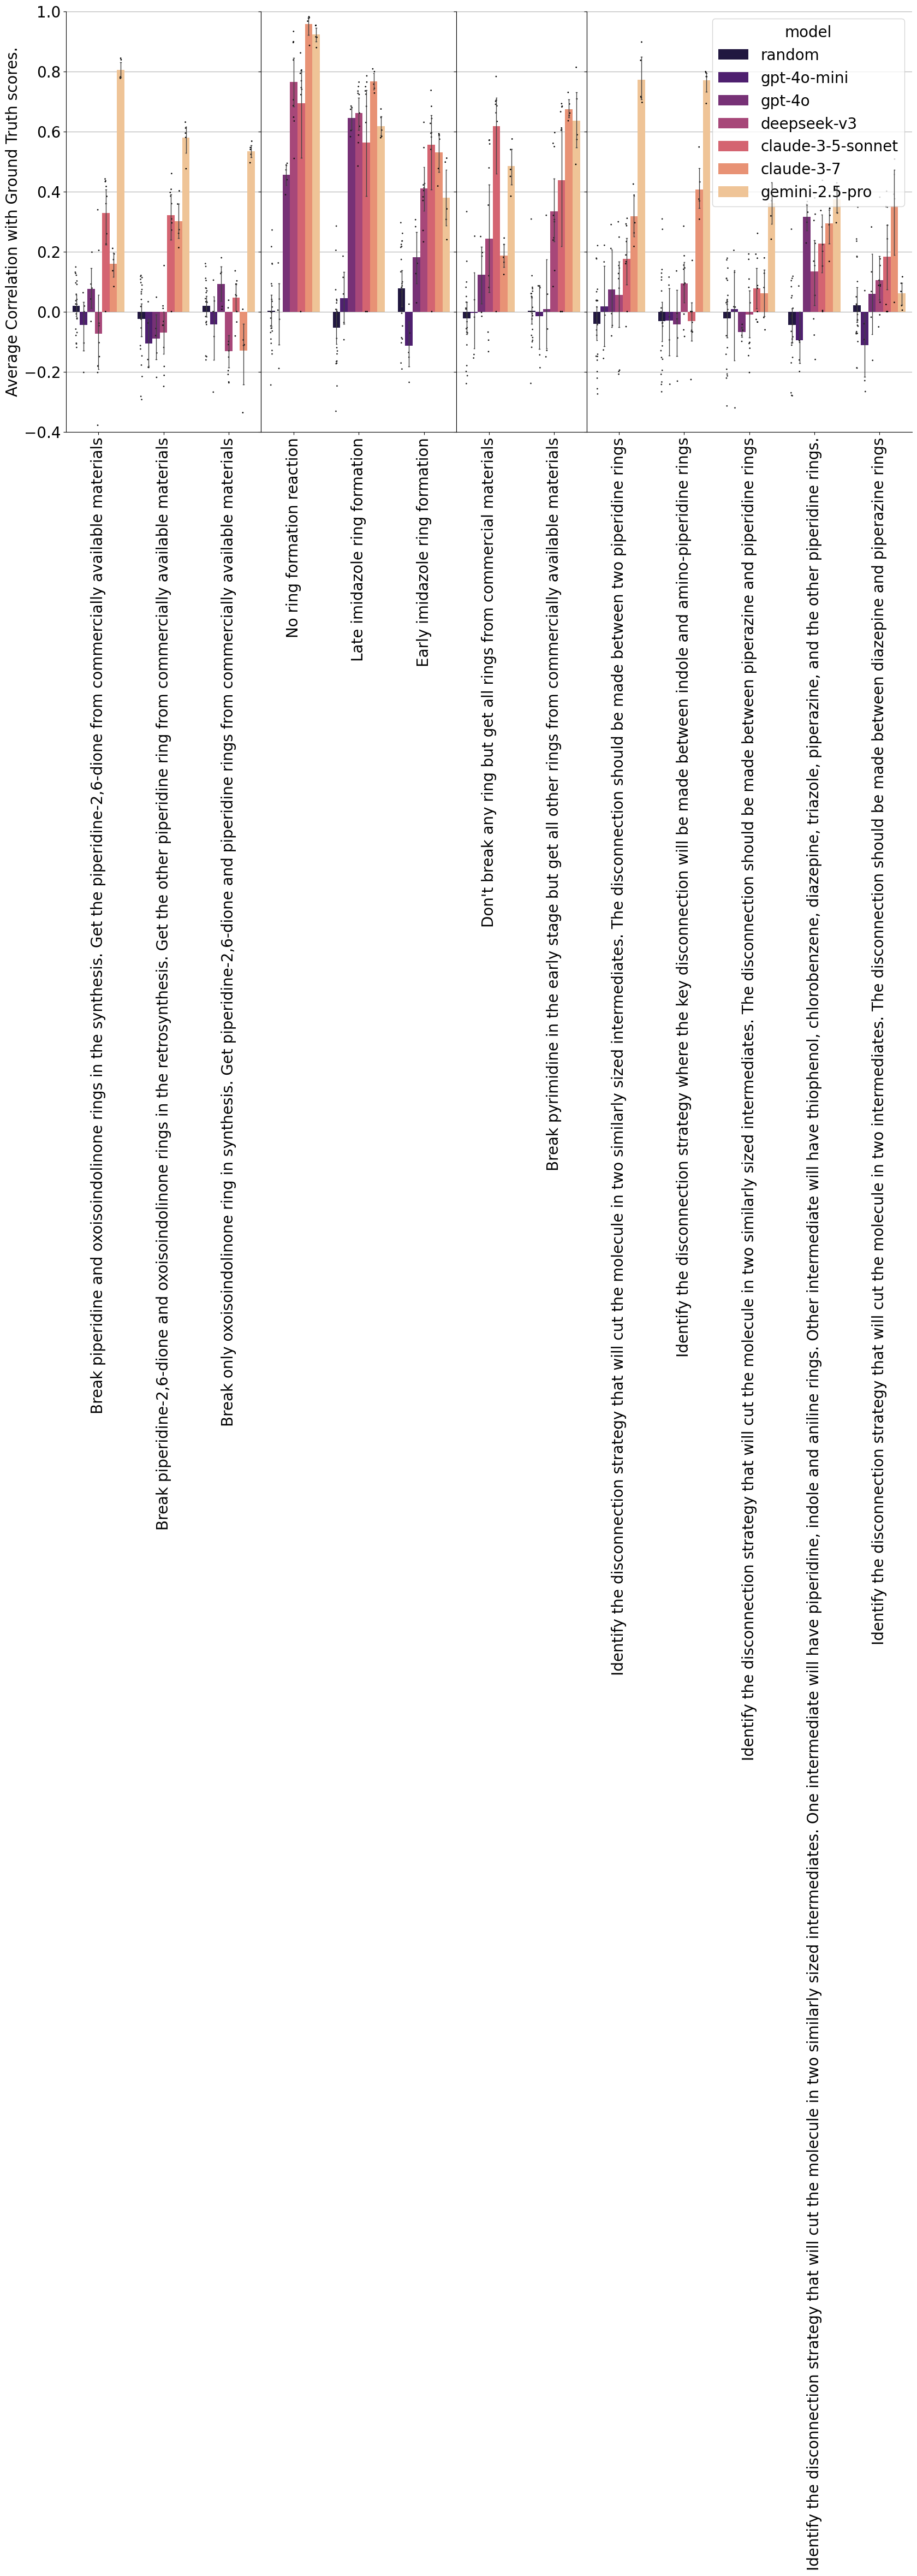

In [7]:
# handle nan values

plt.rcParams['font.size'] = 20

agg = df.replace('NaN', np.nan).fillna(0).melt(id_vars='model', value_vars=corr_cols)

agg = agg.reset_index()
agg['smiles'] = agg['variable'].apply(lambda x: smi[x.split('_')[1]])
agg['prompt'] = agg['variable'].apply(lambda x: prompt[x.split('_')[1]])

wratios = {s:0 for s in smi.values()}
for tid, s in smi.items():
    wratios[s] += 1
wratios = [(k,v, len(k)) for k,v in wratios.items()]
wratios = sorted(wratios, key=lambda x: x[2], reverse=False)

fig, ax = plt.subplots(1,len(wratios), figsize=(20, 10), gridspec_kw={"hspace": 0., "wspace": 0., "width_ratios": [i for s,i,l in wratios]}, sharey=True)

# For each molecule
for i,s in enumerate([s for s,_,_ in wratios]):
    sdata = agg[agg['smiles'] == s].replace('deepseek', 'deepseek-v3')
    sns.barplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=['random', 'gpt-4o-mini', 'gpt-4o', 'deepseek-v3', 'claude-3-5-sonnet', 'claude-3-7', 'gemini-2.5-pro'],
        palette='magma',
        capsize=0.1,
        errorbar='ci',
        err_kws={'linewidth': 1, "zorder":10},
        linewidth=1,
        zorder=5
    )

    sns.stripplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=['random', 'gpt-4o-mini', 'gpt-4o', 'deepseek-v3', 'claude-3-5-sonnet', 'claude-3-7', 'gemini-2.5-pro'],
        palette="dark:k",
        dodge=True,
        jitter=True,
        size=2,
        legend=False,
        zorder=5
    )

    # rotate x labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)

    ax[i].set_xlabel('')
    ax[i].spines['top'].set_visible(False)
    # if i != 0:
    #     # Remove spines
    #     ax[i].yaxis.set_visible(False)
    if i == 3:
        ax[i].spines['right'].set_visible(False)

    # hide legend for all except the last
    if i != 3:
        ax[i].get_legend().remove()

    ax[i].grid(axis='y',zorder=1)
    ax[i].set_ylim(-0.4, 1)
    

ax[0].set_ylabel('Average Correlation with Ground Truth scores.')

# fig.savefig('correlations.svg', dpi=300)

In [8]:
df.groupby(['model','prompt']).apply(len)

model                   prompt                     
claude-2.1              steer.llm.prompts.route_opt     5
claude-3-5-sonnet       steer.llm.prompts.route_opt     9
claude-3-7              steer.llm.prompts.route_opt     5
claude-3-opus           steer.llm.prompts.route_opt     5
claude-3-sonnet         steer.llm.prompts.route_opt     5
claude-4-opus           steer.llm.prompts.route_opt     5
claude-4-sonnet         steer.llm.prompts.route_opt     6
deepseek                steer.llm.prompts.route_opt     5
deepseek-r1             steer.llm.prompts.route_opt     5
deepseek-r1-32b         steer.llm.prompts.route_opt     5
deepseek-r1-70b         steer.llm.prompts.route_opt     5
deepseek-r1-8b          steer.llm.prompts.route_opt     5
deepseek-v3             steer.llm.prompts.route_opt     5
gemini-1.5-flash        steer.llm.prompts.route_opt     5
gemini-1.5-pro          steer.llm.prompts.route_opt     5
gemini-2.0-flash        steer.llm.prompts.route_opt     5
gemini-2.5-pro      

In [9]:
# get the order of the ticks from the figure
from itertools import chain

prompt_order = list(chain(*[[t.get_text() for t in ax[i].get_xticklabels()] for i in range(4)]))

letters = 'ABCDEFGHIJKLMN'
for i,j in zip(letters, prompt_order):
    print(i, " : ", j)

A  :  Break piperidine and oxoisoindolinone rings in the synthesis. Get the piperidine-2,6-dione from commercially available materials
B  :  Break piperidine-2,6-dione and oxoisoindolinone rings in the retrosynthesis. Get the other piperidine ring from commercially available materials
C  :  Break only oxoisoindolinone ring in synthesis. Get piperidine-2,6-dione and piperidine rings from commercially available materials
D  :  No ring formation reaction
E  :  Late imidazole ring formation
F  :  Early imidazole ring formation
G  :  Don't break any ring but get all rings from commercial materials
H  :  Break pyrimidine in the early stage but get all other rings from commercially available materials
I  :  Identify the disconnection strategy that will cut the molecule in two similarly sized intermediates. The disconnection should be made between two piperidine rings
J  :  Identify the disconnection strategy where the key disconnection will be made between indole and amino-piperidine rings
K 

## remake plot but more compressed - agg details

In [10]:
agg = df.replace('NaN', np.nan).melt(id_vars='model', value_vars=corr_cols)

agg = agg.reset_index()
agg['smiles'] = agg['variable'].apply(lambda x: smi[x.split('_')[1]])
agg['prompt'] = agg['variable'].apply(lambda x: prompt[x.split('_')[1]])

agg[agg['model']== 'claude-3-5-sonnet']['value'].mean()
df.dropna(subset=corr_cols)

,_runtime,_step,_timestamp,_wandb,corr_00813afd159c009f6a6c9bf1207b07f4,corr_1002fe2d610a74e4478530e12ab930e3,corr_1823f3241b82133bbca85d6576cbed65,corr_280b79ef56e06a8af1a7d6b72c52148d,corr_46f06d1a1e359b3230cfc1b81473a474,corr_4bfe366ec7f5d64678d500f9084cbb35,...,mae_target3,mae_target4,corr_0c0ea36bcefee71d4956cfc21454fe12,corr_bf6e6641ffc7bf54d328bdb1568e1787,mae_0c0ea36bcefee71d4956cfc21454fe12,mae_bf6e6641ffc7bf54d328bdb1568e1787,model,prompt,vision,results_dir
0,254.584723,13,1736888988.897232,{'runtime': 254},0.166059,0.633014,0.768265,0.784767,0.665338,-0.226217,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-3-5-sonnet,steer.llm.prompts.route_opt,False,data/2025-01-14_220533
1,249.763905,13,1736889151.357946,{'runtime': 249},-0.049988,0.704266,0.739848,0.764098,0.692289,-0.062057,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-3-5-sonnet,steer.llm.prompts.route_opt,False,data/2025-01-14_220820
2,992.182528,13,1736889930.99117,{'runtime': 992},-0.127753,-0.142779,0.162017,0.113924,-0.144098,0.088114,...,NaN,NaN,NaN,NaN,NaN,NaN,gpt-4o-mini,steer.llm.prompts.route_opt,False,data/2025-01-14_220858
3,38.181563,13,1736888995.804186,{'runtime': 37},-0.221706,-0.068395,-0.064843,-0.089364,-0.013737,-0.208782,...,NaN,NaN,NaN,NaN,NaN,NaN,random,steer.llm.prompts.route_opt,False,data/2025-01-14_220916
4,876.810791,13,1736889863.803812,{'runtime': 876},0.210107,0.184499,0.471676,0.673327,-0.150553,-0.024503,...,NaN,NaN,NaN,NaN,NaN,NaN,gpt-4o,steer.llm.prompts.route_opt,False,data/2025-01-14_220946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,528.918436,13,1750755063.259333,{'runtime': 528},-0.020606,0.03786,0.397182,0.298774,0.109205,0.154013,...,NaN,NaN,NaN,NaN,NaN,NaN,gemini-2.0-flash,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_104213
279,2156.69611,13,1750756899.405321,{'runtime': 2156},-0.127178,-0.108622,0.169194,-0.199068,0.196574,0.162478,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-2.1,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_104541
280,608.954177,13,1750755566.14774,{'runtime': 608},0.018355,0.0,0.393878,0.267874,-0.0,0.146379,...,NaN,NaN,NaN,NaN,NaN,NaN,gemini-1.5-pro,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_104916
281,2079.222813,13,1750758994.030276,{'runtime': 2079},-0.190244,-0.287755,0.152158,-0.098991,0.241293,-0.057444,...,NaN,NaN,NaN,NaN,NaN,NaN,claude-2.1,steer.llm.prompts.route_opt,False,data/outputs/2025-06-24_112154


In [11]:
def plot_result_models(lmodels, save_name='model_plots.svg'):
    # handle nan values
    agg = df.replace('NaN', np.nan).dropna(subset=corr_cols).melt(id_vars='model', value_vars=corr_cols)  # dropna or not

    agg = agg.reset_index()
    agg['smiles'] = agg['variable'].apply(lambda x: smi[x.split('_')[1]])
    agg['prompt'] = agg['variable'].apply(lambda x: prompt[x.split('_')[1]])

    wratios = {s:0 for s in smi.values()}
    for tid, s in smi.items():
        wratios[s] += 1
    wratios = [(k,v, len(k)) for k,v in wratios.items()]
    wratios = sorted(wratios, key=lambda x: x[2], reverse=False)

    # append mean subplot
    wratios.append(('mean', 1, 1000))

    agg['model'] = agg['model'].replace('deepseek', 'deepseek-v3')

    agg = agg[agg['model'].isin(lmodels)]

    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

    fig, ax = plt.subplots(1,len(wratios), figsize=(20, 7), gridspec_kw={"hspace": 0., "wspace": 0., "width_ratios": [i for s,i,l in wratios]}, sharey=True)

    # For each molecule
    for i,s in enumerate([s for s,_,_ in wratios]):
        if i!=len(wratios)-1:
            sdata = agg[agg['smiles'] == s]
        else:
            sdata = agg.copy()
            sdata = sdata.groupby(['model','variable','smiles']).mean().reset_index().drop(columns=['index'])
            sdata['prompt'] = "mean"

        sns.barplot(
            data=sdata,
            x='prompt',
            y='value',
            hue='model',
            # alpha=0.6,
            ax=ax[i],
            hue_order=lmodels,
            palette='magma',
            capsize=0.1,
            errorbar='ci',
            err_kws={'linewidth': 1, "zorder":10},
            linewidth=1,
            zorder=5,
        )

        sns.stripplot(
            data=sdata,
            x='prompt',
            y='value',
            hue='model',
            # alpha=0.6,
            ax=ax[i],
            hue_order=lmodels,
            palette="dark:k",
            dodge=True,
            jitter=True,
            size=2,
            legend=False,
            zorder=5
        )

        ax[i].set_xlabel('')
        ax[i].spines['top'].set_visible(False)
        # if i != 0:
        #     # Remove spines
        #     ax[i].yaxis.set_visible(False)
        if i == len(wratios)-1:
            ax[i].spines['right'].set_visible(False)

        # hide legend for all except the last
        # if i != len(wratios)-1:
        ax[i].get_legend().remove()

        ax[i].grid(axis='y',zorder=1)
        ax[i].set_ylim(-0.4, 1)

        cax_ticks = len(ax[i].get_xticks())
        # ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
        ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
        letters = letters[cax_ticks:]

        # Remove bottom spine
        ax[i].spines['bottom'].set_visible(False)
        ax[i].set_xticks([])



    ax[0].set_ylabel('Average Correlation with Ground Truth scores.')

    handles, labels = ax[-1].get_legend_handles_labels()

    # 2. Since you plotted a barplot and stripplot, you have duplicate legend entries.
    #    We'll take only the first set of entries, which corresponds to the barplot.
    num_models = len(lmodels)
    unique_handles = handles[:num_models]
    unique_labels = labels[:num_models]

    # 3. Create a single, figure-level legend below the subplots.
    #    'loc' sets the anchor point on the legend itself. 'bbox_to_anchor' sets where that point goes.
    #    'ncol' arranges the legend into columns.
    fig.legend(
        unique_handles,
        unique_labels,
        loc='lower center',           # Anchor the legend at its bottom-center
        bbox_to_anchor=(0.5, -0.05),  # Position the anchor point at horizontal center and just below the figure
        ncol=4,                       # Arrange legend items in 4 columns
        frameon=False,                # Optional: remove the frame around the legend
        fontsize='medium'
    )

    # 4. Adjust the plot layout to make room for the new legend at the bottom.
    #    The `rect` argument is [left, bottom, right, top]. We shrink the top-to-bottom
    #    space to make room for the legend we placed at y=-0.05.
    fig.tight_layout(rect=[0, 0.05, 1, 1])


    fig.savefig(save_name, dpi=300)

/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:32: FutureWarning: The 

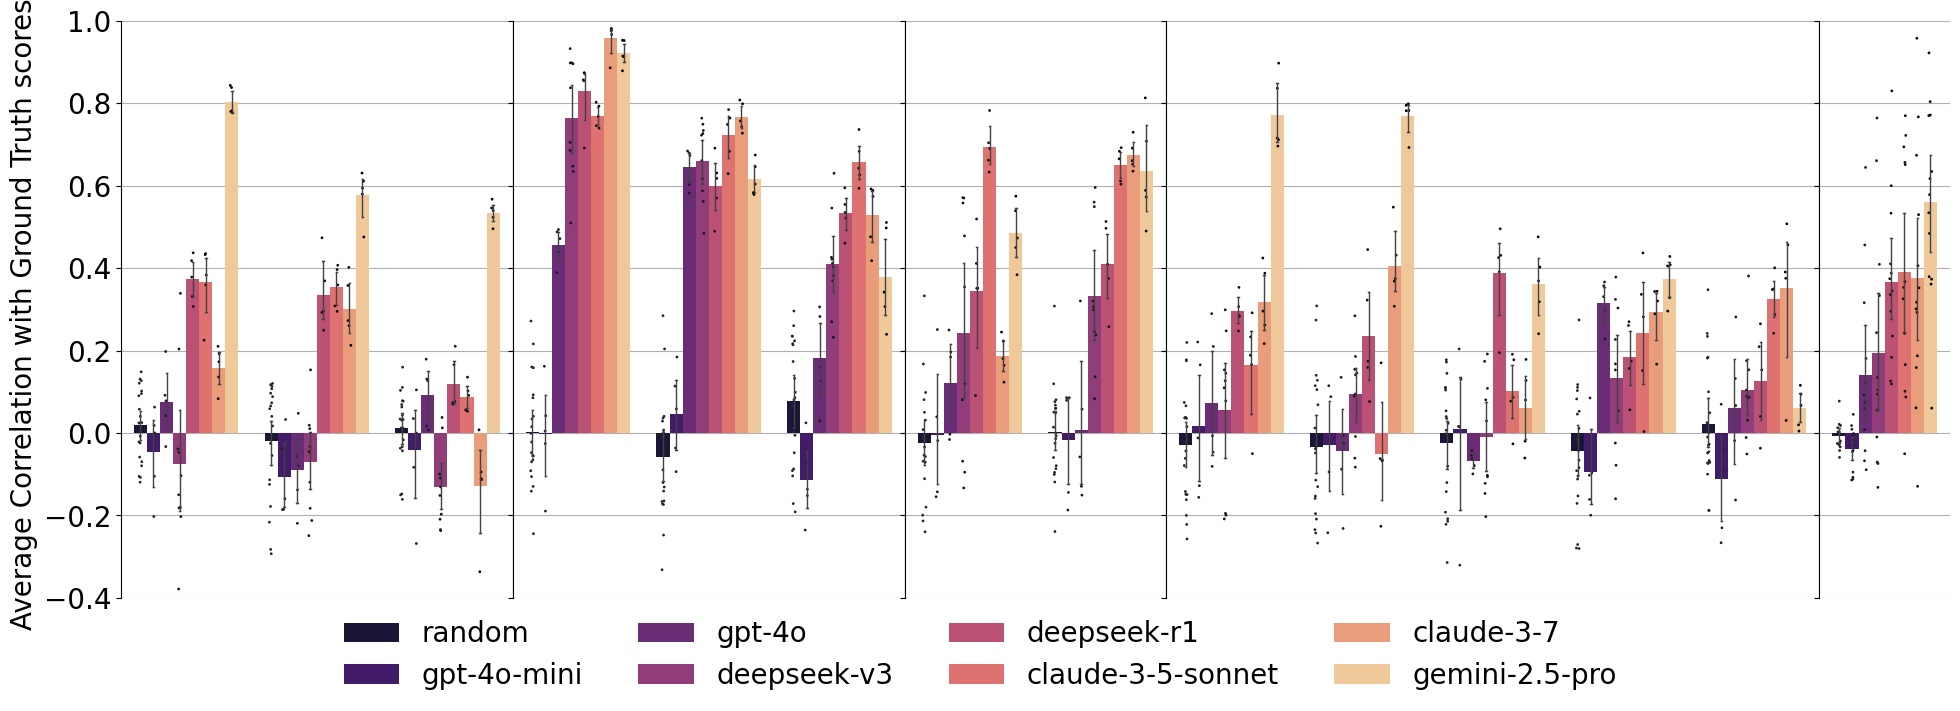

In [12]:
# Main: strong models

lmodels = ['random', 'gpt-4o-mini', 'gpt-4o', 'deepseek-v3', 'deepseek-r1','claude-3-5-sonnet', 'claude-3-7', 'gemini-2.5-pro', ]
plot_result_models(lmodels, save_name='model_plots_strong_models.svg')

/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:32: FutureWarning: The 

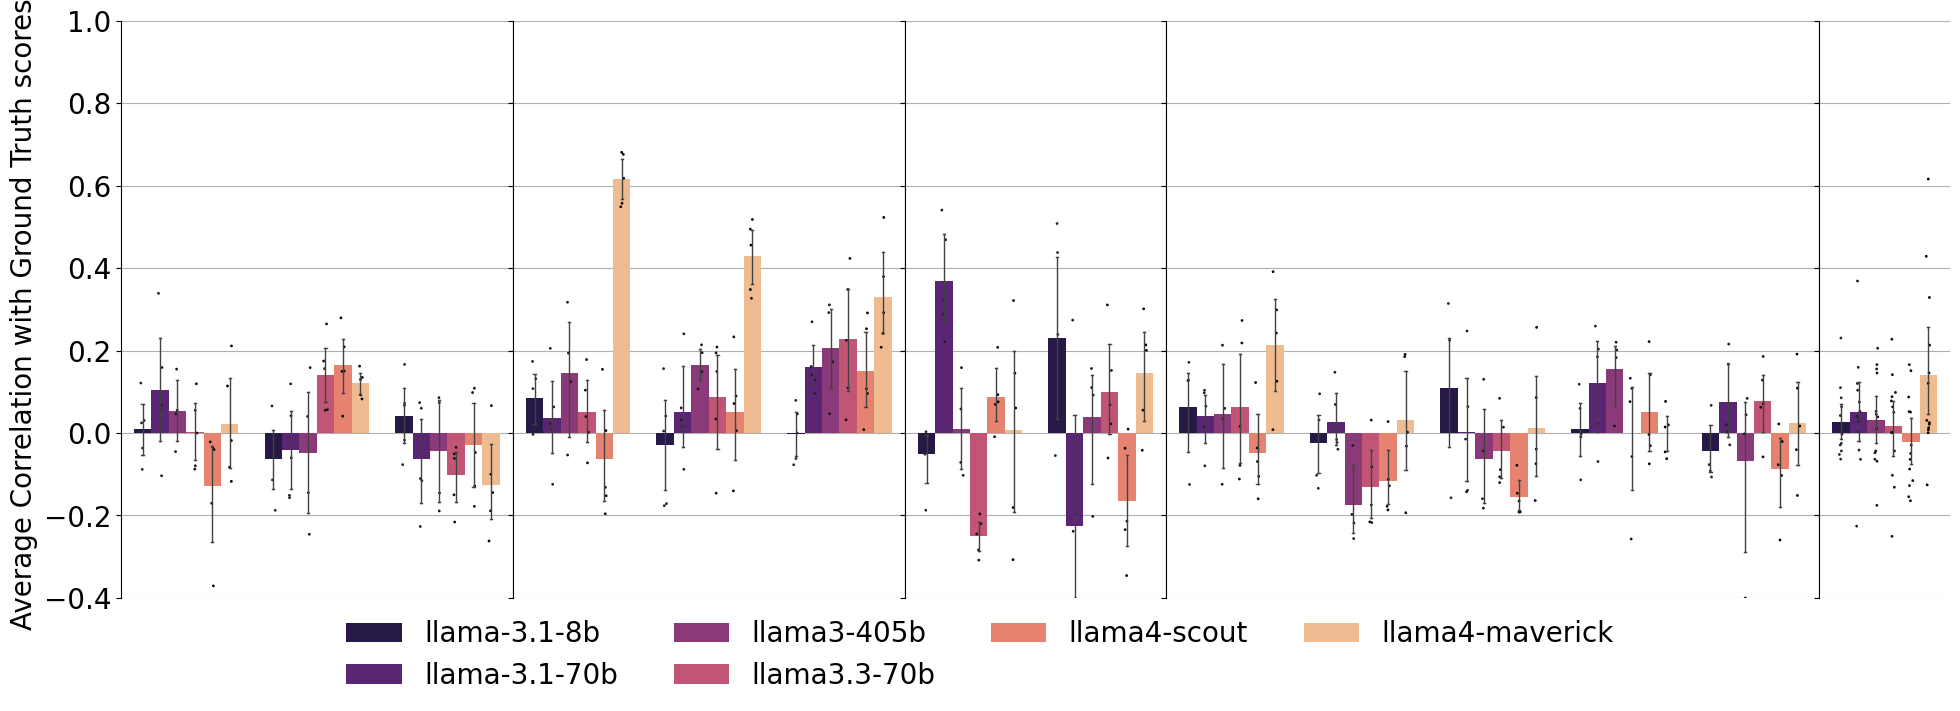

In [13]:
# Llama models
models = [
    'llama-3.1-8b', 'llama-3.1-70b','llama3-405b',
    'llama3.3-70b',
    'llama4-scout', 'llama4-maverick', 
]

plot_result_models(models, save_name='model_plots_llama_models.svg')

/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:32: FutureWarning: The 

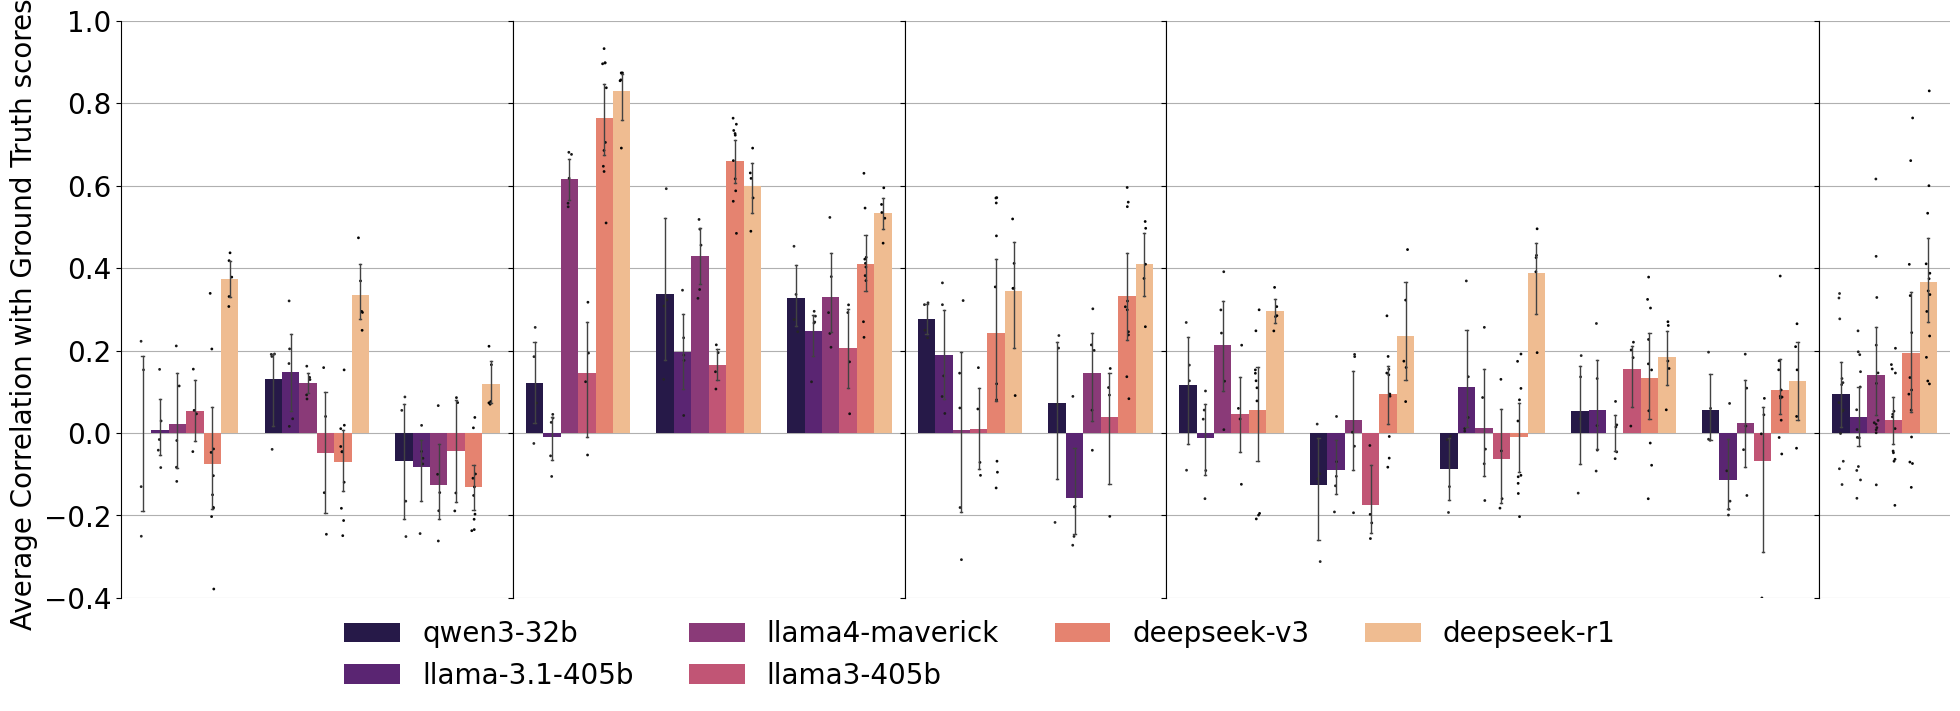

In [14]:
# Flagship open models

models = [
    'qwen3-32b', 
    'llama-3.1-405b',
    'llama4-maverick', 'llama3-405b',
    'deepseek-v3', 'deepseek-r1'
]

plot_result_models(models, save_name='model_plots_flagship_open_models.svg')

/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_3594083/1954806795.py:32: FutureWarning: The 

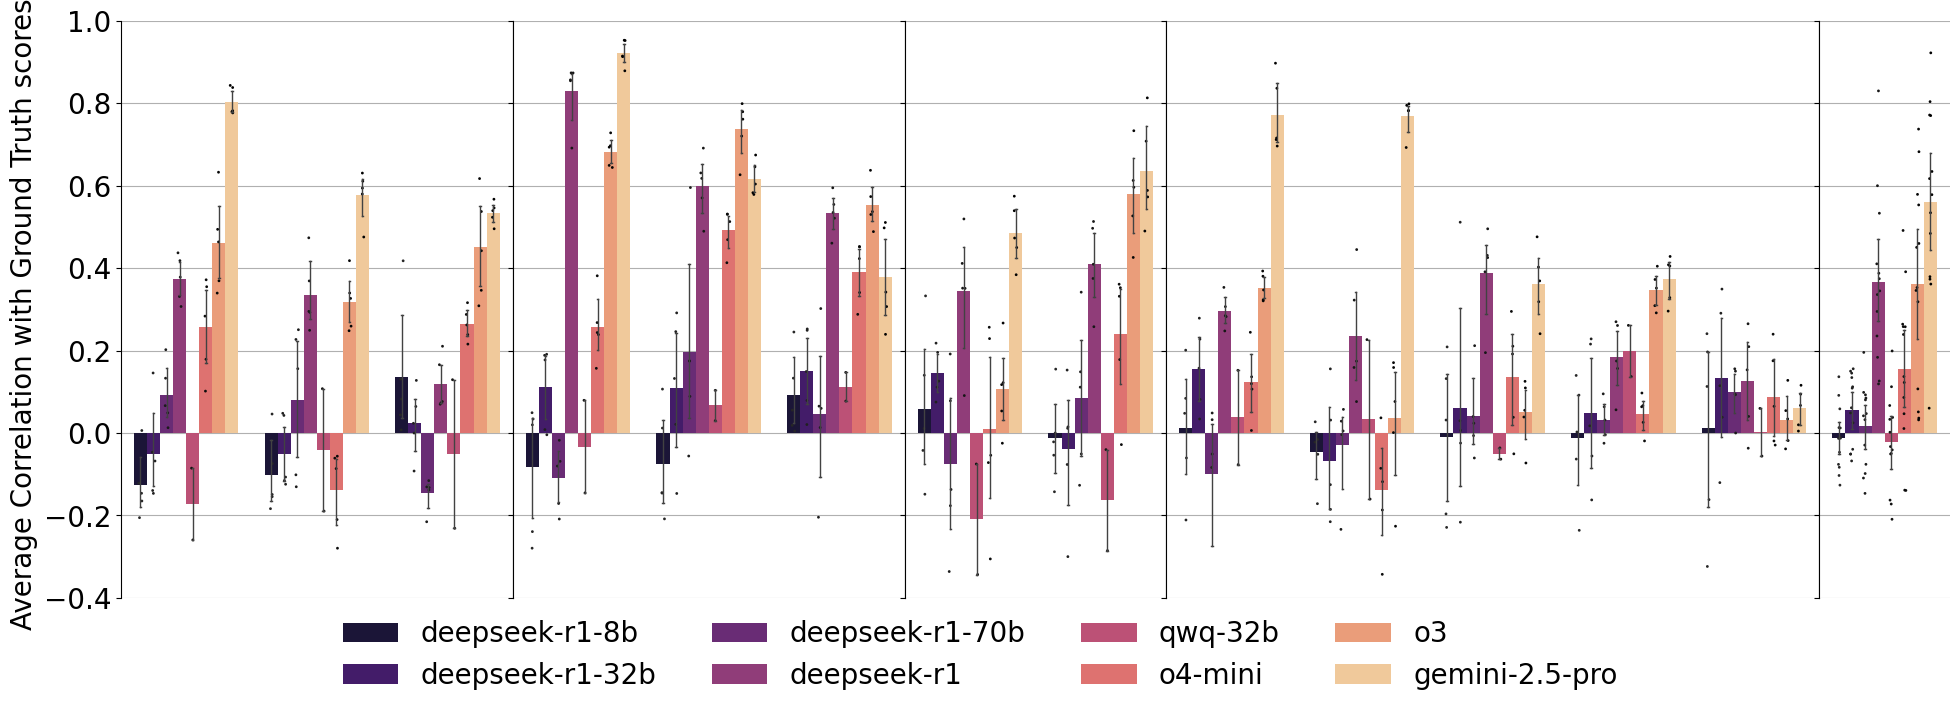

In [15]:
# Reasoning models
models = [
    'deepseek-r1-8b',
    'deepseek-r1-32b',
    'deepseek-r1-70b',
    'deepseek-r1',
    'qwq-32b',
    'o4-mini',
    'o3',
    'gemini-2.5-pro',
]
plot_result_models(models, save_name='model_plots_reasoning_models.svg')

In [16]:
# Now need to make a plot of the aggregated results
# Date vs avg performance

datedf = df.groupby('model')[corr_cols].apply(lambda x: x.astype(float).mean()).mean(axis=1).to_frame()
datedf = datedf.drop(['random', 'llama3-405b', 'llama-3.1-70b']).reset_index()
datedf

,model,0
0,claude-2.1,-0.042367
1,claude-3-5-sonnet,0.386797
2,claude-3-7,0.375088
3,claude-3-opus,0.121480
4,claude-3-sonnet,0.029928
5,claude-4-opus,0.278863
6,claude-4-sonnet,0.289897
7,deepseek,0.136798
8,deepseek-r1,0.367432
9,deepseek-r1-32b,0.056344


In [30]:
model_release_dates = {
    "claude-3-5-sonnet": "2024-06-20",
    "claude-3-7": "2025-02-24",
    "claude-4-sonnet": "2025-05-22",
    "claude-3-sonnet": "2024-03-04",
    "claude-3-opus": "2024-03-04",
    "claude-4-opus": "2025-05-22",
    "claude-2.1": "2023-11-06",
    "deepseek": "2024-12-01",
    "deepseek-r1": "2025-01-20",
    "deepseek-r1-32b": "2025-01-20",
    "deepseek-r1-70b": "2025-01-20",
    "deepseek-r1-8b": "2025-01-20",
    "deepseek-v3": "2025-03-25",
    "gemini-2.5-pro": "2025-06-17",
    "gemini-1.5-pro": "2024-04-09",
    "gemini-1.5-flash": "2024-04-09",
    "gemini-2.0-flash": "2025-02-05",
    "gpt-4-0314": "2023-03-14",
    "gpt-4-1106-preview": "2023-11-06",
    "gpt-4-turbo-2024-04-09": "2024-04-09",
    "gpt-4o": "2024-05-13",
    "gpt-4o-2024-05-13": "2024-05-13",
    "gpt-4o-2024-11-20": "2024-11-20",
    "gpt-4o-mini": "2024-07-18",
    "llama-3-70b": "2024-04-18",
    "llama-3.1-405b": "2024-07-23",
    "llama-3.1-70b": "2024-07-23",
    "llama-3.1-8b": "2024-07-23",
    "llama-3.3-70b": "2024-12-10",
    "llama3-405b": "2024-07-23",
    "llama3.3-70b": "2024-12-10",
    "llama4-maverick": "2025-04-5",
    "llama4-scout": "2025-04-5",
    "o3": "2025-04-16",
    "o4-mini": "2025-04-16",
    "qwen-2-72b": "2024-06-20",
    "qwen3-32b": "2025-04-28",
    "qwq-32b": "2025-03-05",

}

provider_info = {
    'claude':   {'name': 'Anthropic', 'color': '#903d78'},
    'deepseek': {'name': 'DeepSeek', 'color': '#1b1437'},
    'gemini':   {'name': 'Google', 'color': '#dd7170'},
    'gpt':      {'name': 'OpenAI', 'color': '#f0c99a'},
    'o3':      {'name': 'OpenAI', 'color': '#f0c99a'},
    'o4':      {'name': 'OpenAI', 'color': '#FFFFFF'},
    'llama':    {'name': 'Meta', 'color': '#040023'},
    'llama4':    {'name': 'Meta', 'color': '#040023'},
    'llama3':    {'name': 'Meta', 'color': '#040023'},
    'llama3.3':    {'name': 'Meta', 'color': '#009E73'},
    'qwen':     {'name': 'Alibaba', 'color': '#E69F00'},
    'qwq':      {'name': 'Alibaba', 'color': '#E69F00'},
}


datedf['date'] = pd.to_datetime(datedf['model'].map(lambda x: model_release_dates.get(x, "2020-01-01")))


def get_provider_info(model_name, info_key):
    """
    Looks up provider name or color based on the start of the model string.
    """
    # Handle special cases like 'llama3' which doesn't have a hyphen
    if model_name.startswith('llama3'):
        return provider_info['llama'][info_key]
        
    for key, values in provider_info.items():
        if model_name.startswith(key):
            return values[info_key]
    # Return a default if no provider is found
    return 'Other' if info_key == 'name' else '#999999'

# 4. Apply the function to your DataFrame to create the new columns
datedf['provider'] = datedf['model'].apply(lambda x: get_provider_info(x, 'name'))
datedf['color']    = datedf['model'].apply(lambda x: get_provider_info(x, 'color'))


# datedf['color'] = datedf['model'].apply(lambda x: colors.get(x.split('-')[0], '#999999')) # Default to grey

datedf['label'] = False
label_models = [
    "claude-3-5-sonnet", "claude-3-7", "deepseek-r1", 
    "deepseek-v3", "gemini-2.5-pro", "gpt-4-1106-preview", "gpt-4o", "llama4-maverick", "o3", "qwq-32b",
    "gpt-4-2024-11-20", "gpt-4-0314", "o4-mini", "claude-4-sonnet","llama3-70b", "qwen-2-72b", "llama-3.1-70b", "llama-3.1-405b",
    "gpt-4o-2024-11-20", "deepseek",
    "llama-3-70b", "qwen3-32b", "claude-3-opus", "gemini-1.5-pro", "gemini-2.0-flash"
    
]
for m in label_models:
    datedf.loc[datedf['model'] == m, 'label'] = True

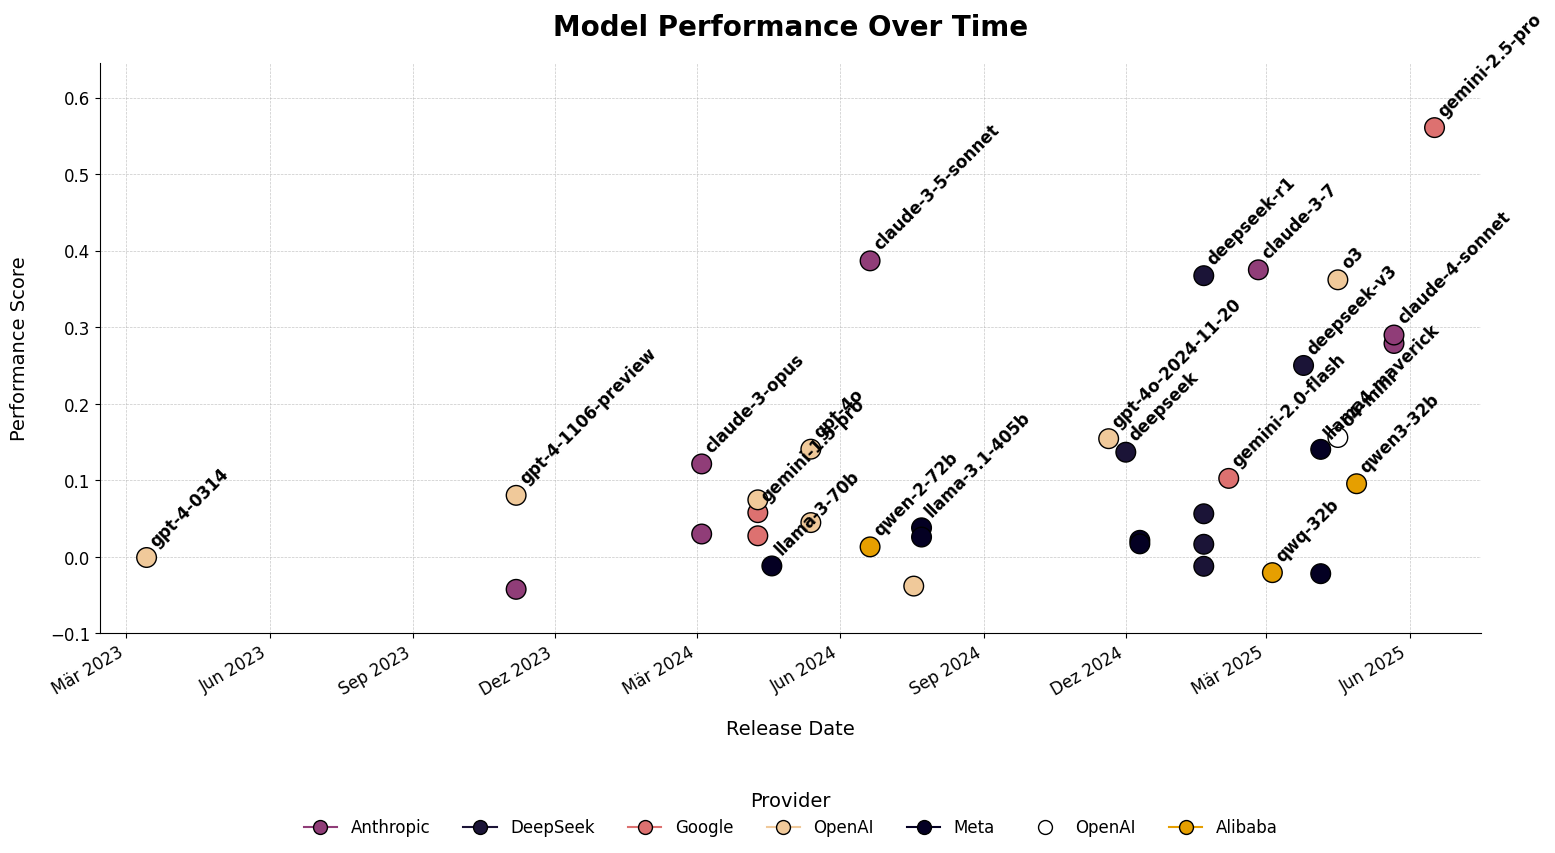

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.lines as mlines  # <-- Import 'lines' for creating legend handles


fig, ax = plt.subplots(figsize=(16, 9))

# Create the scatter plot using our new 'color' column
# We increase the size 's' and add an 'edgecolor' for better visibility
sns.scatterplot(
    data=datedf,
    x='date',
    y=0,
    color=datedf['color'], # Use the explicit color column
    s=200,             # Larger points are easier to see
    ax=ax,
    edgecolor='black', # Adds a nice definition to the points
    linewidth=1,
    zorder=3           # Ensure points are drawn on top of the grid
)

# --- 4. Add Conditional Labels ---

# Filter for the points we want to label
df_to_label = datedf[datedf['label']]

for idx, row in df_to_label.iterrows():
    ax.text(
        x=row['date'],
        y=row[0] + 0.01, # Add a small vertical offset
        s=row['model'],  # The text is the model name
        fontdict={'size': 12, 'weight': 'bold', 'color': 'black'},
        ha='left',       # Horizontal alignment
        va='bottom',      # Vertical alignment
        rotation=45,  # Rotate text for better readability
    )


# --- 5. Polish and Style the Plot ---

# --- 2. Create and Add the Custom Legend (New Section) ---

# Get unique providers and their colors from your data for the legend
unique_providers = datedf[['provider', 'color']].drop_duplicates()

# Create a list of "proxy artists" for the legend
legend_handles = [
    mlines.Line2D(
        [], [], # No data
        color=row['color'],
        marker='o',
        markeredgecolor='black', # Edge color for visibility
        markersize=10,
        label=row['provider']
    ) for index, row in unique_providers.iterrows()
]

# Place the legend at the bottom of the plot
ax.legend(
    handles=legend_handles,
    title='Provider',
    title_fontsize='14',
    loc='upper center', # Location relative to the bbox_to_anchor
    bbox_to_anchor=(0.5, -0.25), # Position legend below the plot (0.5=center, -0.1=just below)
    ncol=len(unique_providers), # Number of columns in the legend
    frameon=False, # Remove the legend box frame
    fontsize='12'
)


# Set informative title and axis labels
ax.set_title('Model Performance Over Time', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Release Date', fontsize=14, labelpad=15)
ax.set_ylabel('Performance Score', fontsize=14, labelpad=15)

# Improve axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Format the x-axis for dates to be readable
# Use a clear format (e.g., 'Jan 2024') and set ticks every few months
locator = mdates.MonthLocator(interval=3)
formatter = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate() # Automatically rotates date labels

# Add a subtle grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)

# Set plot limits to give some breathing room
ax.set_ylim(-0.1, datedf[0].max() * 1.15)
ax.set_xlim(datedf['date'].min() - pd.Timedelta(days=30), datedf['date'].max() + pd.Timedelta(days=30))

# Remove top and right spines for a cleaner look
sns.despine()

# Ensure everything fits without overlapping
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('model_performance_over_time.svg', dpi=300, bbox_inches='tight')

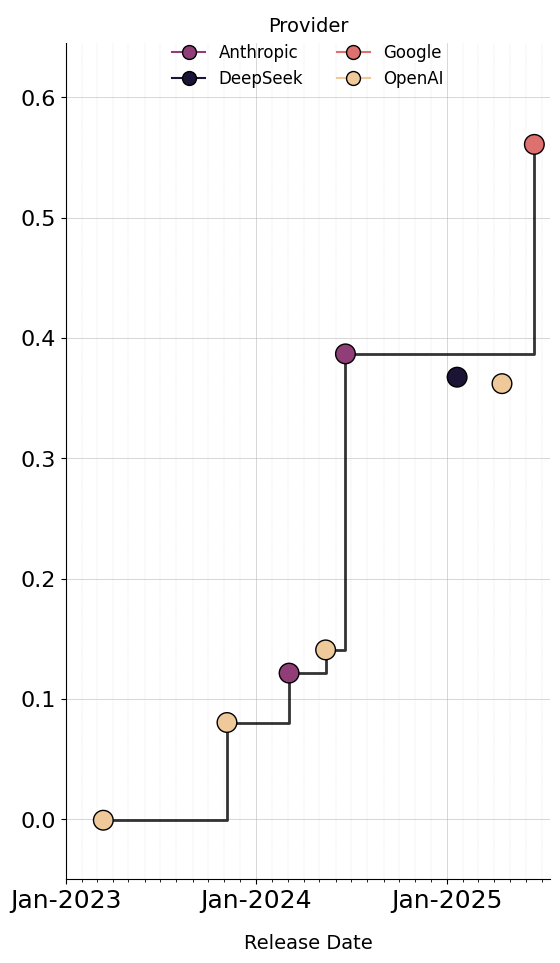

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.lines as mlines  # <-- Import 'lines' for creating legend handles

only_show = [
    "claude-3-5-sonnet", "deepseek-r1", 
    "gemini-2.5-pro", "gpt-4-1106-preview", "gpt-4o",
    "gpt-4-0314", "o3",
    "claude-3-opus"
]
    
datedf_filt = datedf[datedf['model'].isin(only_show)]


fig, ax = plt.subplots(figsize=(6, 10))

# Create the scatter plot using our new 'color' column
# We increase the size 's' and add an 'edgecolor' for better visibility
sns.scatterplot(
    data=datedf_filt,
    x='date',
    y=0,
    color=datedf_filt['color'], # Use the explicit color column
    s=200,             # Larger points are easier to see
    ax=ax,
    edgecolor='black', # Adds a nice definition to the points
    linewidth=1,
    zorder=3           # Ensure points are drawn on top of the grid
)

# Sort by date to ensure proper line plotting
datedf_sorted = datedf_filt.sort_values('date')

# Calculate the running maximum (best performance) up to each date
datedf_sorted['best_so_far'] = datedf_sorted[0].expanding().max()

# Plot as a step function
ax.step(
    datedf_sorted['date'], 
    datedf_sorted['best_so_far'],
    where='post',  # Step occurs after each point
    color='black',
    linewidth=2,
    alpha=0.8,
    zorder=2,
    label='Best Performance Frontier'
)



# --- 4. Add Conditional Labels ---

# Filter for the points we want to label
df_to_label = datedf_filt[datedf_filt['label']]

# for idx, row in df_to_label.iterrows():
#     ax.text(
#         x=row['date']- pd.Timedelta(days=60),  # Adjust horizontal position for better spacing
#         y=row[0] - 0.01, # Add a small vertical offset
#         s=row['model'],  # The text is the model name
#         fontdict={'size': 12, 'weight': 'bold', 'color': 'black'},
#         ha='left',       # Horizontal alignment
#         va='bottom',      # Vertical alignment
#         rotation=0,  # Rotate text for better readability
#     )


# --- 5. Polish and Style the Plot ---

# --- 2. Create and Add the Custom Legend (New Section) ---

# Get unique providers and their colors from your data for the legend
unique_providers = datedf_filt[['provider', 'color']].drop_duplicates()

# Create a list of "proxy artists" for the legend
legend_handles = [
    mlines.Line2D(
        [], [], # No data
        color=row['color'],
        marker='o',
        markeredgecolor='black', # Edge color for visibility
        markersize=10,
        label=row['provider']
    ) for index, row in unique_providers.iterrows()
]

# Place the legend at the bottom of the plot
ax.legend(
    handles=legend_handles,
    title='Provider',
    title_fontsize='14',
    loc='upper center', # Location relative to the bbox_to_anchor
    bbox_to_anchor=(0.5, 1.05), # Position legend below the plot (0.5=center, -0.1=just below)
    ncol=2, # Number of columns in the legend
    frameon=False, # Remove the legend box frame
    fontsize='12'
)


# Set informative title and axis labels
# ax.set_title('Model Performance Over Time', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Release Date', fontsize=14, labelpad=15)
ax.set_ylabel('', fontsize=14, labelpad=15)

# Improve axis ticks
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='x', which='minor', labelsize=18)

# Format the x-axis for dates to be readable
# Major ticks: Years
major_locator = mdates.YearLocator()  # Every year
major_formatter = mdates.DateFormatter('%b-%Y')

# Minor ticks: Months
minor_locator = mdates.MonthLocator(interval=1)


ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_minor_locator(minor_locator)

# fig.autofmt_xdate() # Automatically rotates date labels

# Add a subtle grid for better readability
ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7, zorder=0)
ax.grid(True, which='minor', linestyle='--', linewidth=0.3, alpha=0.4, zorder=0)


# Set the fontsize of y ticks to 16
ax.tick_params(axis='y', labelsize=16)


# Set plot limits to give some breathing room
ax.set_ylim(-0.05, datedf[0].max() * 1.15)
ax.set_xlim(pd.to_datetime('2023-01-01'), datedf['date'].max() + pd.Timedelta(days=30))

# Remove top and right spines for a cleaner look
sns.despine()

# Ensure everything fits without overlapping
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('evol_reduced.svg', dpi=300, bbox_inches='tight')